# AEDWIP
```
Andrew E. Davidson
aedavids@ucsc.edu
```

ref:
- extraCellularRNA/terra/deseq/doc/plots
- extraCellularRNA/terra/deseq/doc/plots/jupyterNotebooks/GTExValidateExploration.ipynb
- https://support.terra.bio/hc/en-us/articles/360042259232-Managing-data-and-automating-workflows-with-the-FISS-API
- [An introduction to using the Fiss API in Python in BioData Catalyst](https://terra.biodatacatalyst.nhlbi.nih.gov/#workspaces/biodata-catalyst/BioData%20Catalyst%20Collection/notebooks/launch/Intro%20to%20FISS%20API%20in%20Python.ipynb)

## TODO:
1. find top genes
    + ~~Top up regulated~~
    + Top downn regulated
    + Top up and down
2. ~~run createDataSetCSV.sh~~
3. ~~run geneSignatureUpsetPlot.py~~
4. ~~display plots~~
5. ~~display intersection~~
6. save plots and intersection to gcp bucket



## ???
- how do we capture/store design info?

In [1]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%Y-%b-%d %H:%M:%S")
print("Run on ", current_time)

Run on  2022-Jul-02 01:30:06


In [2]:
from firecloud import fiss
import firecloud.api as fapi
import os
import io
import pandas as pd
from pathlib import Path

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display, Image

## Configure 

In [3]:
terraDataEntity = "GTEx_1vsAll"
PADJ_THRESHOLD = 0.001
lfcThreshold = 2.0
topN = 25
#design = "~ sex + tissue_id".replace(" ", "")
designStr = "~sex+tissue_id"
outDir = "output"
! mkdir -p $outDir

outputImgDir = outDir + "/img"
! mkdir -p $outputImgDir

In [4]:
tmp = "./tmp"
!mkdir -p $tmp

In [5]:
# set env var used by fiss
# Get the Google billing project name and workspace name
billing_project = os.environ['WORKSPACE_NAMESPACE']
workspace = os.environ['WORKSPACE_NAME']
bucket = os.environ['WORKSPACE_BUCKET'] + "/"

print("Billing project: " + billing_project)
print("Workspace: " + workspace)
print("Workspace storage bucket: " + bucket)

Billing project: test-aedavids-proj
Workspace: uber
Workspace storage bucket: gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/


In [6]:
# Install a pip package in the current Jupyter kernel
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
!{sys.executable} -m pip install --quiet upsetplot

# install upset plot
# see extraCellularRNA/terra/deseq/bin/createUpsetPlotZip.sh
url = bucket + "python/upsetPlot.zip"
! gsutil cp $url .
! unzip -o upsetPlot.zip > /dev/null
ORIG_PYTHONPATH = os.environ['PYTHONPATH']

Copying gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/python/upsetPlot.zip...
/ [1 files][ 13.0 MiB/ 13.0 MiB]                                                
Operation completed over 1 objects/13.0 MiB.                                     


In [7]:
PYTHONPATH = ORIG_PYTHONPATH + ":./python"
os.environ["PYTHONPATH"] = PYTHONPATH
PYTHONPATH = os.environ["PYTHONPATH"]
print("PYTHONPATH: {}".format(PYTHONPATH))

# test install
! python python/plots/geneSignatureUpsetPlot.py

PYTHONPATH: /etc/jupyter/custom:/usr/lib/spark/python:/home/jupyter/packages:./python
usage: geneSignatureUpsetPlot.py [-h] [-t] -d  -o
geneSignatureUpsetPlot.py: error: the following arguments are required: -d/--dataSetsCSV, -o/--outputFile


## Find Up Regulated Genes

In [8]:
def listWorkspaceEntities():
    '''
    prints out the names of all the workspace data models, and the number of rows in each model
    
    returns void
    '''
    # Take a look at all of the data models / entities in of our workspace
    ent_types = fiss.fapi.list_entity_types(billing_project, workspace).json()
    for t in ent_types.keys():
        print (t, "count:", ent_types[t]['count'])
        
listWorkspaceEntities()        

GTEx_1vsAll count: 51
GTEx_1vsAll_set count: 2
TCGA_1vsAll count: 32
TCGA_1vsAll_set count: 2


In [9]:
def loadTerraDataModel(billingProject, workspace, modelName) :
    '''
    returns a pandas dataframe
    '''
    ret = pd.read_csv( io.StringIO(
                                    fiss.fapi.get_entities_tsv(
                                        billing_project, 
                                        workspace, 
                                        modelName,
                                        model='flexible')
                                    .text), 
                              sep='\t')
    return ret

terraDataEntityDF = loadTerraDataModel(billing_project, workspace, terraDataEntity)

In [10]:
def select1vsAllResults(df):
    '''
    select rows where candidateSignatureGeneProfile is not null
    
    returns a pandas dataframe
    '''
    selectRowsLogical = ~df.loc[:,'candidateSignatureGeneProfile'].isnull()
    retDF = df.loc[selectRowsLogical, :]
    
    return retDF  

In [11]:
terraDataEntityDF = select1vsAllResults(terraDataEntityDF)
    
print("{}.shape:{}".format(terraDataEntity, terraDataEntityDF.shape))

print("\n")
for f in terraDataEntityDF.loc[:,'candidateSignatureGeneProfile'].to_list():
    print( f.split("/")[-1] )

terraDataEntityDF.head()

GTEx_1vsAll.shape:(8, 3)


Adipose_Subcutaneous_vs_all.results
Colon_Sigmoid_vs_all.results
Colon_Transverse_vs_all.results
Kidney_Cortex_vs_all.results
Liver_vs_all.results
Lung_vs_all.results
Pancreas_vs_all.results
Whole_Blood_vs_all.results


,entity:GTEx_1vsAll_id,candidateSignatureGeneProfile,tissueId
0,GTEX_Adipose_Subcutaneous,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/b...,Adipose_Subcutaneous
24,GTEX_Colon_Sigmoid,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/d...,Colon_Sigmoid
25,GTEX_Colon_Transverse,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/d...,Colon_Transverse
31,GTEX_Kidney_Cortex,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/c...,Kidney_Cortex
32,GTEX_Liver,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/c...,Liver


In [12]:
def downLoadCandidateSignatureGeneProfile(cache, dataModelDF):
    '''
    downloads candidateSignatureGeneProfile files to local disk if not already in local cache
    
    arguments:
        cache : 
            string path to director to store files location
        
        dataModelDF
            example, GTEx_1vsAllDF
            
    returns
        list of file path on local machine
    '''
    retList = []
    resultsList = dataModelDF.loc[:, 'candidateSignatureGeneProfile'].to_list()
    for gsURL in resultsList:
        fileName = gsURL.split("/")[-1]
        savePath = cache + "/" + fileName
        path = Path(savePath)
        if path.is_file() :
            print("skipping download of {}".format(fileName))            
        else:
            !gsutil -m cp $gsURL $savePath
            
        retList.append(savePath)
            
    return retList
            
        
csgpFileList = downLoadCandidateSignatureGeneProfile(tmp, terraDataEntityDF)

skipping download of Adipose_Subcutaneous_vs_all.results
skipping download of Colon_Sigmoid_vs_all.results
skipping download of Colon_Transverse_vs_all.results
skipping download of Kidney_Cortex_vs_all.results
skipping download of Liver_vs_all.results
skipping download of Lung_vs_all.results
skipping download of Pancreas_vs_all.results
skipping download of Whole_Blood_vs_all.results


In [13]:
def findUpRegulatedSignatureGenes(deseqDF, topN=25, lfcThreshold=2.0, padjThreshold=PADJ_THRESHOLD):
    '''
    Find genes that that are statistically signifigant and up requlated
    
    arguments:
        deseqDF:
            results of DESeq2 as a pandas dataframe 
            
        topN:
            The number of genes to select
            default = 25
        
        lfcThreshold:
            log fold threshold. selectes genes with lfc >=
            default = 2.0
            
        padjThreshold:
            p value
            default = PADJ_THRESHOLD
    
    return:
        pandas dataframe
    '''
    selectSignificantRowsPS = deseqDF.loc[:,"padj"] < padjThreshold
#     print("number of genes with padj < {} : {}".format(padjThreshold,
#                                                        selectSignificantRowsPS.sum()))

    deseqLFCSignatureGenesDF = deseqDF.loc[ selectSignificantRowsPS,: ]\
                                        .sort_values("log2FoldChange", ascending=False)
    
    # find the genes that are over expresed 
    selectLFCPS = deseqLFCSignatureGenesDF.loc[:,"log2FoldChange"] >= lfcThreshold
#     print("number of genes with log2FoldChange >= {} = {}"\
#             .format( lfcThreshold, selectLFCPS.sum() ))
    
    deseqBaseMeanSignatureGenesDF = deseqLFCSignatureGenesDF.loc[ selectLFCPS,: ]\
                            .sort_values("baseMean", ascending=False)
    
    topSignatureGenesDF = deseqBaseMeanSignatureGenesDF.head( topN )
    return topSignatureGenesDF

In [14]:
def runFindUpRegulated( csgpFileList, outDir, topN=topN, lfcThreshold=lfcThreshold, 
                       padjThreshold=PADJ_THRESHOLD, skipRows=7 ):
    '''
    finds ups up regulated genes
    saves to disk as CSV file
    
    arguments:
        csgpFileList: 
            a list of file paths to candidate signature gene files to include in upset plot
            
        outDir:
            String
            path to directory to save up regulated genes
            
        topN:
            an integer: 
            number of genes to select. 
        
        lfcThreshold:
            float: 
            log fold change threshold. example 2.0
            
        padjThreshold
            float:
            p-value threshold. example 0.001
            
        skipRows:
            int, default = 7
            1vsAll returns the results from DESeq with a self describing header comprised of 7 rows
            the lfcShrink output has 6 rows 
            
    returns: (upRegulatedDict, outFileList)
        upRegulatedDict : dictionary
            key: csgpFile name
            value: pandas dataframe
        
    '''
    retDict = {}
    retOutFileList = []
    for csgpFile in csgpFileList:
        deseqDF = pd.read_csv(csgpFile, skiprows=skipRows)
        topSignatureGenesDF = findUpRegulatedSignatureGenes(deseqDF,
                                                            topN=25, 
                                                            lfcThreshold=2.0,
                                                            padjThreshold=PADJ_THRESHOLD)

        fileName = csgpFile.split("/")[-1]
        outFilePath = outDir + "/" + fileName
        topSignatureGenesDF.to_csv(outFilePath, index=False)
        print("saved to file: {}".format(outFilePath))

        retDict[fileName] = topSignatureGenesDF
        retOutFileList.append(outFilePath)

    
    return (retDict, retOutFileList)

In [15]:
upRegulatedDict, outFileList =  runFindUpRegulated(csgpFileList, outDir, topN, lfcThreshold, PADJ_THRESHOLD, skipRows=7)
for key in upRegulatedDict.keys():
    df = upRegulatedDict[key]
    print("\n" + key)
    display(df.head(n=2))

saved to file: output/Adipose_Subcutaneous_vs_all.results
saved to file: output/Colon_Sigmoid_vs_all.results
saved to file: output/Colon_Transverse_vs_all.results
saved to file: output/Kidney_Cortex_vs_all.results
saved to file: output/Liver_vs_all.results
saved to file: output/Lung_vs_all.results
saved to file: output/Pancreas_vs_all.results
saved to file: output/Whole_Blood_vs_all.results

Adipose_Subcutaneous_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2598,ADH1B,17143.164164,2.570108,0.110754,23.205528,4.004105e-119,6.787105e-118
3330,SCD,14955.789895,2.337709,0.109592,21.330950,5.860552e-101,7.750849e-100



Colon_Sigmoid_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
7342,DES,107581.586211,2.109197,0.197579,10.675197,1.329758e-26,7.751820e-26
1729,FLNA,97685.816741,2.122092,0.121730,17.432822,4.649417e-68,1.150422e-66



Colon_Transverse_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
4839,ACTG2,25046.871730,2.339475,0.191002,12.248409,1.713248e-34,1.496296e-33
1495,IGHA1,15249.871559,3.577475,0.196995,18.160241,1.065564e-73,3.010860e-72



Kidney_Cortex_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1157,GPX3,41541.842214,3.026442,0.258996,11.685293,1.515568e-31,5.236299e-30
9364,CD24,6492.377939,2.013442,0.386504,5.209367,1.894859e-07,8.095185e-07



Liver_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
62,ALB,27493.769756,10.317529,0.263922,39.093050,0.000000e+00,0.000000e+00
1703,SERPINA1,22225.903094,6.755015,0.260880,25.893186,7.947042e-148,2.203858e-146



Lung_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
219,A2M,29256.720012,3.092535,0.085033,36.368635,1.333821e-289,2.645271e-287
284,EPAS1,14177.932721,2.501200,0.071410,35.025817,9.104605e-269,1.393835e-266



Pancreas_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
119,PRSS2,67944.739711,13.095938,0.230060,56.924005,0.0,0.0
118,PRSS1,60016.825354,13.352346,0.226817,58.868382,0.0,0.0



Whole_Blood_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
3309,HBB,1.213707e+06,11.394454,0.110845,102.796395,0.0,0.0
3308,HBA2,1.157728e+06,11.412815,0.106920,106.741872,0.0,0.0


## create dataSet.csv
This file is an argument to plots/geneSignatureUpsetPlot.py. I defines the set of candidate genes to include
in the upset plot

In [16]:
def createDataSetCSV(csgpFileList):
    retDF = None
    for csgp in csgpFileList:
        setName = csgp.split("/")[-1]
        filePath = csgp
        numHeaderLines = 8

        tmpDF = pd.DataFrame( {"setName":[setName], 'numHeaderLines':[numHeaderLines], 'filePath':[filePath]} )
        if retDF is None:
            retDF = tmpDF
        else:
            byRows = 0
            retDF = pd.concat([retDF, tmpDF], axis=byRows, ignore_index=True)
            
    return retDF
        
        
dataSetDF = createDataSetCSV(outFileList)
dataSetPath = outDir + "/dataSet.csv"
dataSetDF.to_csv(dataSetPath , index=False)
dataSetDF

,setName,numHeaderLines,filePath
0,Adipose_Subcutaneous_vs_all.results,8,output/Adipose_Subcutaneous_vs_all.results
1,Colon_Sigmoid_vs_all.results,8,output/Colon_Sigmoid_vs_all.results
2,Colon_Transverse_vs_all.results,8,output/Colon_Transverse_vs_all.results
3,Kidney_Cortex_vs_all.results,8,output/Kidney_Cortex_vs_all.results
4,Liver_vs_all.results,8,output/Liver_vs_all.results
5,Lung_vs_all.results,8,output/Lung_vs_all.results
6,Pancreas_vs_all.results,8,output/Pancreas_vs_all.results
7,Whole_Blood_vs_all.results,8,output/Whole_Blood_vs_all.results


## Create Upset Plot

In [17]:
title = "{} topN={} Signature Genes, padj < {} lf2c > {} sorted by baseMean".format(terraDataEntity, topN, PADJ_THRESHOLD, lfcThreshold)

print("title: {}".format(title))
name= terraDataEntity + "-" + designStr

outputImg =  outputImgDir + "/" + name + ".png"
print("outputImg: {}".format(outputImg))

! python python/plots/geneSignatureUpsetPlot.py \
    -t "$title" \
    -d "$dataSetPath" \
    -o "$outputImg"

title: GTEx_1vsAll topN=25 Signature Genes, padj < 0.001 lf2c > 2.0 sorted by baseMean
outputImg: output/img/GTEx_1vsAll-~sex+tissue_id.png
Namespace(dataSetsCSV='output/dataSet.csv', outputFile='output/img/GTEx_1vsAll-~sex+tissue_id.png', title='GTEx_1vsAll topN=25 Signature Genes, padj < 0.001 lf2c > 2.0 sorted by baseMean')
                               setName  ...                                    filePath
0  Adipose_Subcutaneous_vs_all.results  ...  output/Adipose_Subcutaneous_vs_all.results
1         Colon_Sigmoid_vs_all.results  ...         output/Colon_Sigmoid_vs_all.results
2      Colon_Transverse_vs_all.results  ...      output/Colon_Transverse_vs_all.results
3         Kidney_Cortex_vs_all.results  ...         output/Kidney_Cortex_vs_all.results
4                 Liver_vs_all.results  ...                 output/Liver_vs_all.results
5                  Lung_vs_all.results  ...                  output/Lung_vs_all.results
6              Pancreas_vs_all.results  ...            

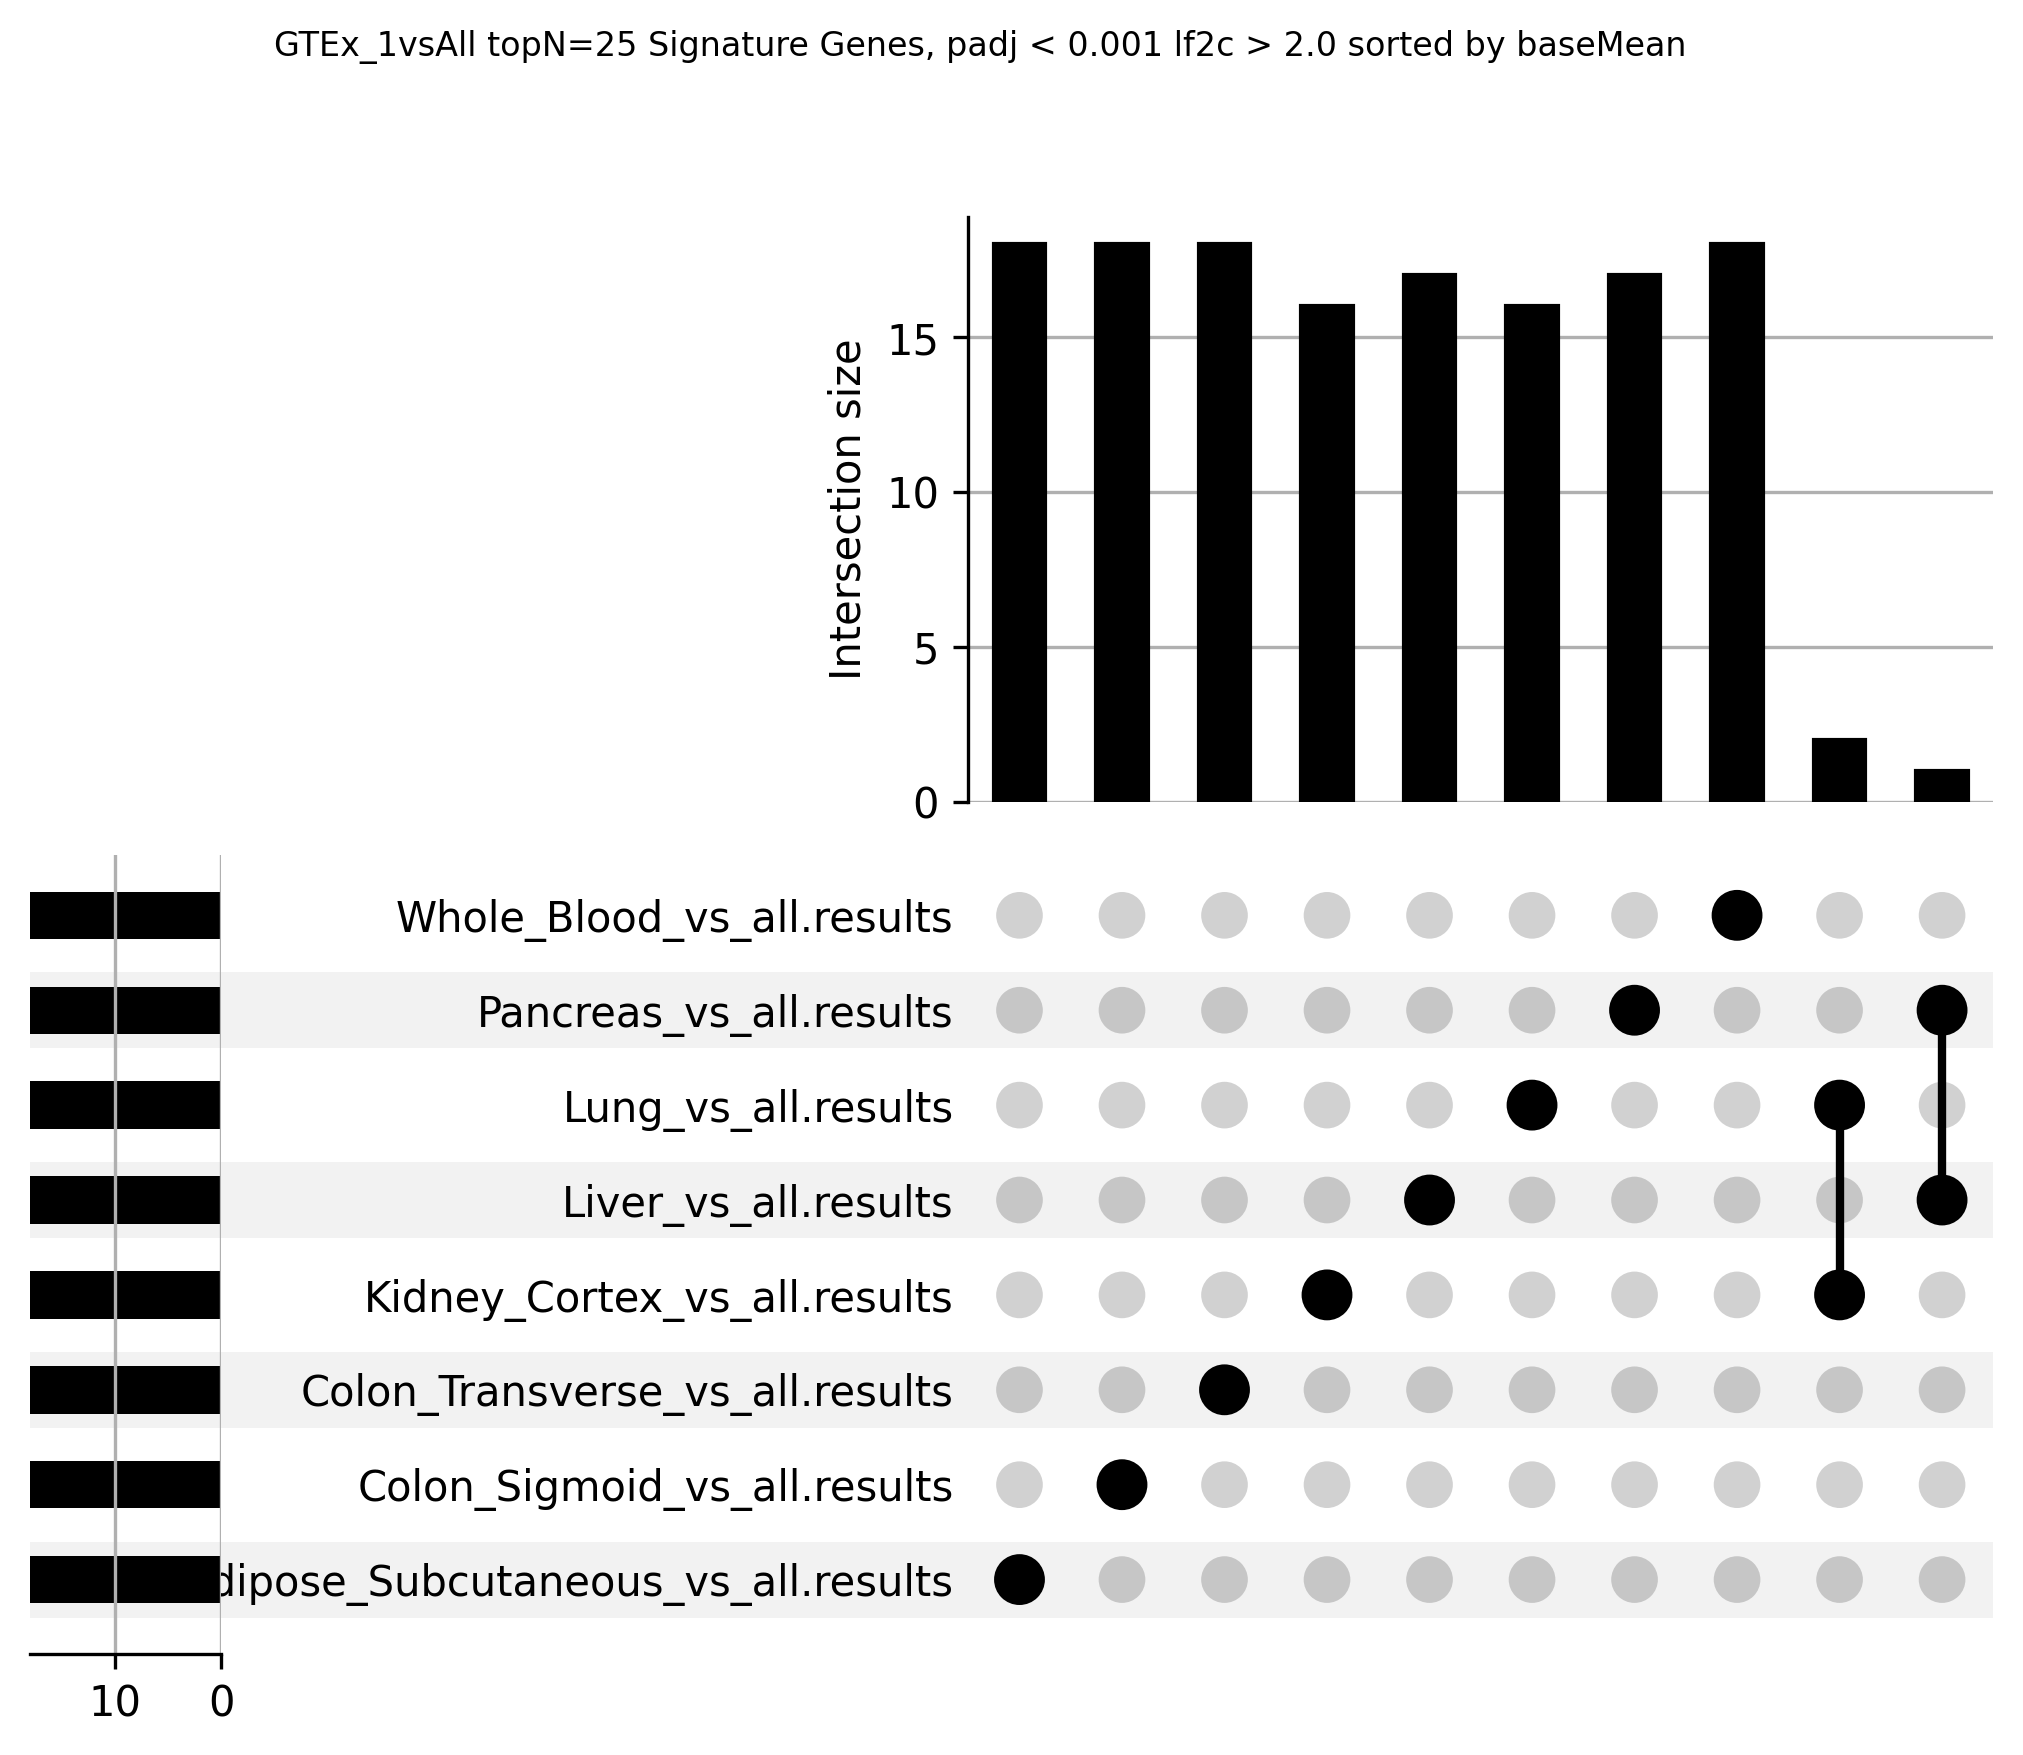

In [18]:
#from IPython.display import Image
display( Image(filename=outputImg) )


## Explore the intersections

In [21]:
intersectionDF = pd.read_csv("geneSignatureUpsetPlot.Intersection.csv")
intersectionDF.loc[:, ['tissueId', 'gene']]

,tissueId,gene
0,Kidney_Cortex_vs_all.results,MUC1
1,Lung_vs_all.results,MUC1
2,Kidney_Cortex_vs_all.results,CTSH
3,Lung_vs_all.results,CTSH
4,Liver_vs_all.results,SERPINA3
5,Pancreas_vs_all.results,SERPINA3
